In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

In [2]:
dataset='NATOPS'

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test



In [4]:
print(train_x.shape)
print(X_train.shape)

(180, 24, 51)
(180, 51, 24)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))



In [6]:
n_pred_classes =train_y.shape[1]
print('n pred classes',n_pred_classes) 
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


n pred classes 6


In [7]:
model = ResNetBaseline(in_channels= X_train.shape[-1], num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)
#test_preds=np.argmax(test_preds,axis=1)
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../ClassificationModels/models/{dataset}/classification_report.csv', index = False)



Epoch: 1, Train loss: 1.144, Val loss: 1.286
Epoch: 2, Train loss: 0.833, Val loss: 0.664
Epoch: 3, Train loss: 0.602, Val loss: 0.618
Epoch: 4, Train loss: 0.489, Val loss: 0.521
Epoch: 5, Train loss: 0.547, Val loss: 0.402
Epoch: 6, Train loss: 0.577, Val loss: 0.489
Epoch: 7, Train loss: 0.495, Val loss: 0.383
Epoch: 8, Train loss: 0.354, Val loss: 0.546
Epoch: 9, Train loss: 0.514, Val loss: 0.481
Epoch: 10, Train loss: 0.438, Val loss: 0.679
Epoch: 11, Train loss: 0.396, Val loss: 0.414
Epoch: 12, Train loss: 0.331, Val loss: 0.519
Epoch: 13, Train loss: 0.336, Val loss: 0.388
Epoch: 14, Train loss: 0.303, Val loss: 0.313
Epoch: 15, Train loss: 0.347, Val loss: 0.448
Epoch: 16, Train loss: 0.386, Val loss: 0.7
Epoch: 17, Train loss: 0.35, Val loss: 0.465
Epoch: 18, Train loss: 0.327, Val loss: 0.332
Epoch: 19, Train loss: 0.347, Val loss: 0.464
Epoch: 20, Train loss: 0.274, Val loss: 0.553
Epoch: 21, Train loss: 0.287, Val loss: 0.594
Epoch: 22, Train loss: 0.368, Val loss: 0.335


In [8]:
print(train_x.shape)
print(test_x.shape)
print(X_train.shape[-1])

(180, 24, 51)
(180, 24, 51)
24


# Explanation Algo

In [9]:
item=test_x[10].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [10]:
print(y_target)

[[1.2321502e-13 5.7847837e-14 4.3873754e-12 6.3140874e-08 9.9996996e-01
  2.9965555e-05]]


In [11]:
(train_x,train_y)

(array([[[-0.372758, -1.821679, -0.846321, ..., -0.378445, -1.821358,
          -0.839571],
         [ 0.471135, -2.010042, -0.832021, ...,  0.611207, -1.953282,
          -0.902529],
         [-0.57355 , -0.79973 , -0.169575, ..., -0.597853, -0.785186,
          -0.263083],
         ...,
         [ 0.484961, -1.488929, -0.636533, ...,  0.505991, -1.501208,
          -0.618588],
         [-0.586057, -1.683287, -0.604036, ..., -0.572906, -1.567532,
          -0.557784],
         [ 0.541325, -1.691657, -0.716364, ...,  0.571569, -1.721661,
          -0.741532]],
 
        [[-0.54737 , -1.600105, -0.809446, ..., -0.549748, -1.595734,
          -0.812398],
         [ 0.554836, -1.670118, -0.747451, ...,  0.557987, -1.669932,
          -0.744497],
         [-0.668654, -0.672274, -0.161632, ..., -0.669179, -0.672573,
          -0.160717],
         ...,
         [ 0.635732, -1.38227 , -0.462377, ...,  0.641761, -1.241242,
          -0.389806],
         [-0.698562, -1.475496, -0.653505, ..., -

In [12]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import BruteForceSearch, OptimizedSearch,AtesCF

#comte = OptimizedSearch(model, train_x, np.argmax(train_y,axis=1), silent=False, threads=1,num_distractors=2)
exp_model= AtesCF(model,(train_x,train_y),backend='PYT',mode='feat')
#exp_model=NativeGuideCF(model,shape,(train_x,train_y), mode='torch')

2022-06-13 12:38:33.634705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 12:38:33.634722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
#TODO Brute --> workig but long runttime ? or somehow endless loop 
#TODO KD TRee somehow zero --> checkout 
exp = exp_model.explain(item,3, method= 'opt')
#exp=comte.explain(item,to_maximize=np.argmax(y_target,axis=1)[0],savefig=False) #from abc import ABC, abstractmethod#exp_model.explain(item, np.argmax(y_target,axis=1),method='native_guide')

Target [3]


In [14]:
exp

(array([[[-0.479743, -1.791929, -0.903477, ..., -0.479274, -1.79115 ,
          -0.899316],
         [ 0.523864, -1.874153, -0.666274, ...,  0.525813, -1.873512,
          -0.661249],
         [-0.69437 , -0.678901, -0.336247, ..., -0.694311, -0.675182,
          -0.337719],
         ...,
         [ 0.871105, -1.413926, -0.383612, ...,  0.933799, -1.427527,
          -0.132535],
         [-1.215168, -1.578678, -0.574377, ..., -1.122646, -1.589755,
          -0.611878],
         [ 1.001135, -1.718158, -0.386636, ...,  0.931226, -1.700317,
          -0.434918]]]),
 array([3]))

In [15]:
print(exp[0])
array, label=exp
print(label)
print(array)

[[[-0.479743 -1.791929 -0.903477 ... -0.479274 -1.79115  -0.899316]
  [ 0.523864 -1.874153 -0.666274 ...  0.525813 -1.873512 -0.661249]
  [-0.69437  -0.678901 -0.336247 ... -0.694311 -0.675182 -0.337719]
  ...
  [ 0.871105 -1.413926 -0.383612 ...  0.933799 -1.427527 -0.132535]
  [-1.215168 -1.578678 -0.574377 ... -1.122646 -1.589755 -0.611878]
  [ 1.001135 -1.718158 -0.386636 ...  0.931226 -1.700317 -0.434918]]]
[3]
[[[-0.479743 -1.791929 -0.903477 ... -0.479274 -1.79115  -0.899316]
  [ 0.523864 -1.874153 -0.666274 ...  0.525813 -1.873512 -0.661249]
  [-0.69437  -0.678901 -0.336247 ... -0.694311 -0.675182 -0.337719]
  ...
  [ 0.871105 -1.413926 -0.383612 ...  0.933799 -1.427527 -0.132535]
  [-1.215168 -1.578678 -0.574377 ... -1.122646 -1.589755 -0.611878]
  [ 1.001135 -1.718158 -0.386636 ...  0.931226 -1.700317 -0.434918]]]


# Plot Item 

In [16]:
plt.style.use("classic")
colors = [
            '#08F7FE',  # teal/cyan
            '#FE53BB',  # pink
            '#F5D300',  # yellow
            '#00ff41',  # matrix green
        ]
        
#Figure out number changed channels
##index= np.argwhere(np.any(item!=array,axis=1))
#index
res = (item != array).any(-1)
ind=np.where(res[0])

print(res)
print(ind[0][0])

[[False False False False False  True  True  True  True  True False  True
   True  True  True  True  True  True  True  True  True False False False]]
5


In [17]:
len(ind[0])

15

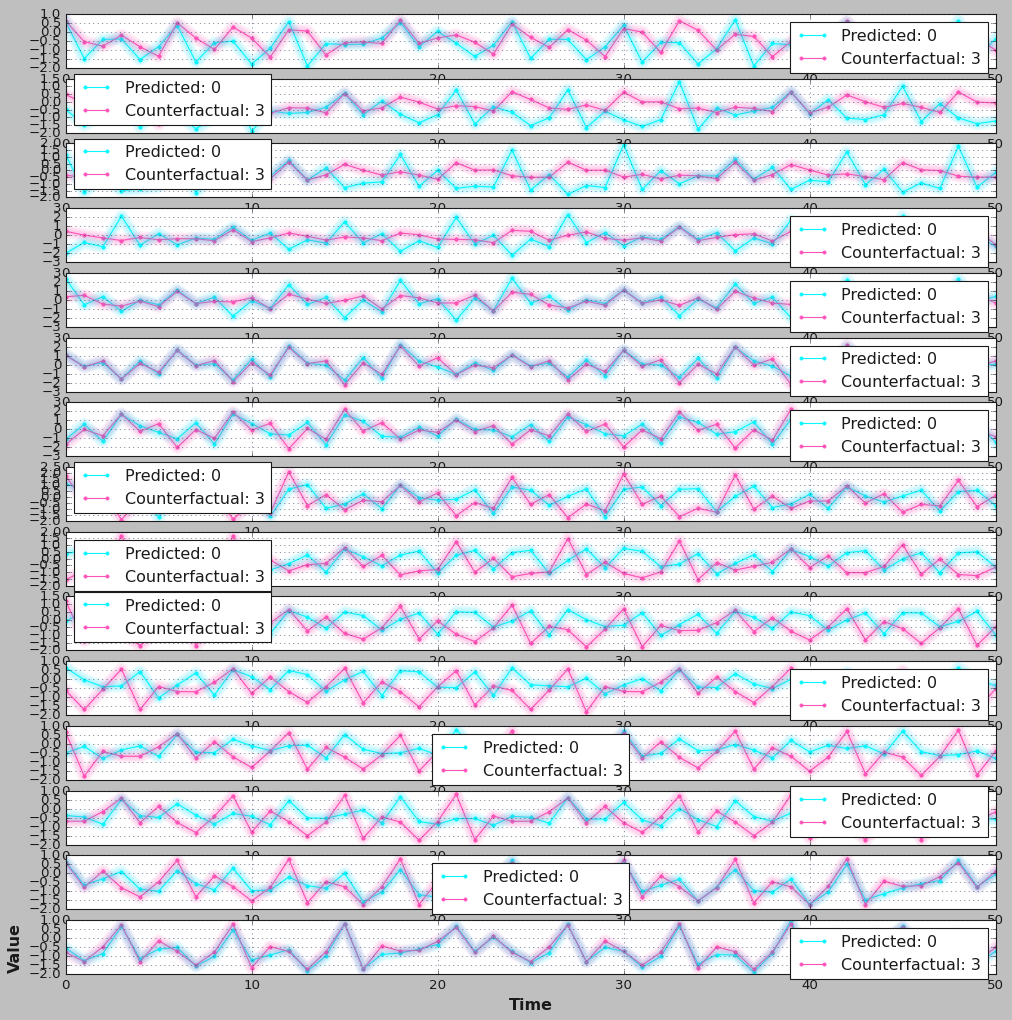

In [18]:
i=0
org_label=0
cf_label=label[0]
exp=array

exp_model.plot(item,org_label,exp,cf_label,figsize=(15,15))